In [82]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
import lightgbm as lgb
from matplotlib.gridspec import GridSpec
from collections import Counter
from scipy.stats import norm
from scipy import stats
from scipy.special import boxcox1p
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: f'{x: .3f}')
%matplotlib inline

In [130]:
# load files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

all_data = pd.concat([train, test]).reset_index(drop=True).drop('SalePrice', axis=1)
y_train = train['SalePrice']
train_ID = train['Id']
test_ID = test['Id']

In [131]:
# Display the first 5 rows of the train dataset.
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5   
1   2          20       RL       80.000     9600   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story            6            8   
2   3          60       RL       68.000    11250   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5   
3   4          70       RL       60.000     9550   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story            7            5   
4   5          60       RL       84.000    14260   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam     2Story            8            5   

   YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
0       2003          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace     196.000        Gd        TA      PConc       Gd       TA           No          GLQ         706          Unf   
1       1976          1976     Gable  CompShg     MetalSd     MetalSd       None       0.000        TA        TA     CBlock       Gd       TA           Gd          ALQ         978          Unf   
2       2001          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace     162.000        Gd        TA      PConc       Gd       TA           Mn          GLQ         486          Unf   
3       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng       None       0.000        TA        TA     BrkTil       TA       Gd           No          ALQ         216          Unf   
4       2000          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace     350.000        Gd        TA      PConc       Gd       TA           Av          GLQ         655          Unf   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0           0        150          856    GasA        Ex          Y      SBrkr       856       854             0       1710             1             0         2         1             3   
1           0        284         1262    GasA        Ex          Y      SBrkr      1262         0             0       1262             0             1         2         0             3   
2           0        434          920    GasA        Ex          Y      SBrkr       920       866             0       1786             1             0         2         1             3   
3           0        540          756    GasA        Gd          Y      SBrkr       961       756             0       1717             1             0         1         0             3   
4           0        490         1145    GasA        Ex          Y      SBrkr      1145      1053             0       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  \
0             1          Gd             8        Typ           0         NaN     Attchd     2003.000          RFn           2         548         TA         TA          Y           0           61   
1             1          TA             6        Typ           1          TA     Attchd     1976.000          RFn   

In [38]:
# Display the first 5 rows of the train dataset.
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
0  1461          20       RH       80.000    11622   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl        NAmes      Feedr       Norm     1Fam     1Story            5            6   
1  1462          20       RL       81.000    14267   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl        NAmes       Norm       Norm     1Fam     1Story            6            6   
2  1463          60       RL       74.000    13830   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story            5            5   
3  1464          60       RL       78.000     9978   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story            6            6   
4  1465         120       RL       43.000     5005   Pave   NaN      IR1         HLS    AllPub    Inside       Gtl      StoneBr       Norm       Norm   TwnhsE     1Story            8            5   

   YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
0       1961          1961     Gable  CompShg     VinylSd     VinylSd       None       0.000        TA        TA     CBlock       TA       TA           No          Rec     468.000          LwQ   
1       1958          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace     108.000        TA        TA     CBlock       TA       TA           No          ALQ     923.000          Unf   
2       1997          1998     Gable  CompShg     VinylSd     VinylSd       None       0.000        TA        TA      PConc       Gd       TA           No          GLQ     791.000          Unf   
3       1998          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace      20.000        TA        TA      PConc       TA       TA           No          GLQ     602.000          Unf   
4       1992          1992     Gable  CompShg     HdBoard     HdBoard       None       0.000        Gd        TA      PConc       Gd       TA           No          ALQ     263.000          Unf   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0     144.000    270.000      882.000    GasA        TA          Y      SBrkr       896         0             0        896         0.000         0.000         1         0             2   
1       0.000    406.000     1329.000    GasA        TA          Y      SBrkr      1329         0             0       1329         0.000         0.000         1         1             3   
2       0.000    137.000      928.000    GasA        Gd          Y      SBrkr       928       701             0       1629         0.000         0.000         2         1             3   
3       0.000    324.000      926.000    GasA        Ex          Y      SBrkr       926       678             0       1604         0.000         0.000         2         1             3   
4       0.000   1017.000     1280.000    GasA        Ex          Y      SBrkr      1280         0             0       1280         0.000         0.000         2         0             2   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  \
0             1          TA             5        Typ           0         NaN     Attchd     1961.000          Unf       1.000     730.000         TA         TA          Y         140            0   
1             1          Gd             6        Typ           0         NaN     Attchd     1958.000      

In [39]:
# Data Overview
print('train data: %d rows, %d columns.' % train.shape)
print('test data: %d rows, %d columns.' % test.shape)
print('Overview'.center(50, '-'))
print(train.info())
# Index column: Id, target column: SalePrice, 36 numeric columns, 43 categorical columns.

train data: 1460 rows, 81 columns.
test data: 1459 rows, 80 columns.
---------------------Overview---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     146

------------Missing values(col_num=34)------------
              missing_count  missing_rate
PoolQC                 2909         0.997
MiscFeature            2814         0.964
Alley                  2721         0.932
Fence                  2348         0.804
FireplaceQu            1420         0.486
LotFrontage             486         0.166
GarageQual              159         0.054
GarageFinish            159         0.054
GarageYrBlt             159         0.054
GarageCond              159         0.054
GarageType              157         0.054
BsmtCond                 82         0.028
BsmtExposure             82         0.028
BsmtQual                 81         0.028
BsmtFinType2             80         0.027
BsmtFinType1             79         0.027
MasVnrType               24         0.008
MasVnrArea               23         0.008
MSZoning                  4         0.001
BsmtFullBath              2         0.001
BsmtHalfBath              2         0.001
Utilities                

Text(0.5, 1.0, 'Missing Rate')

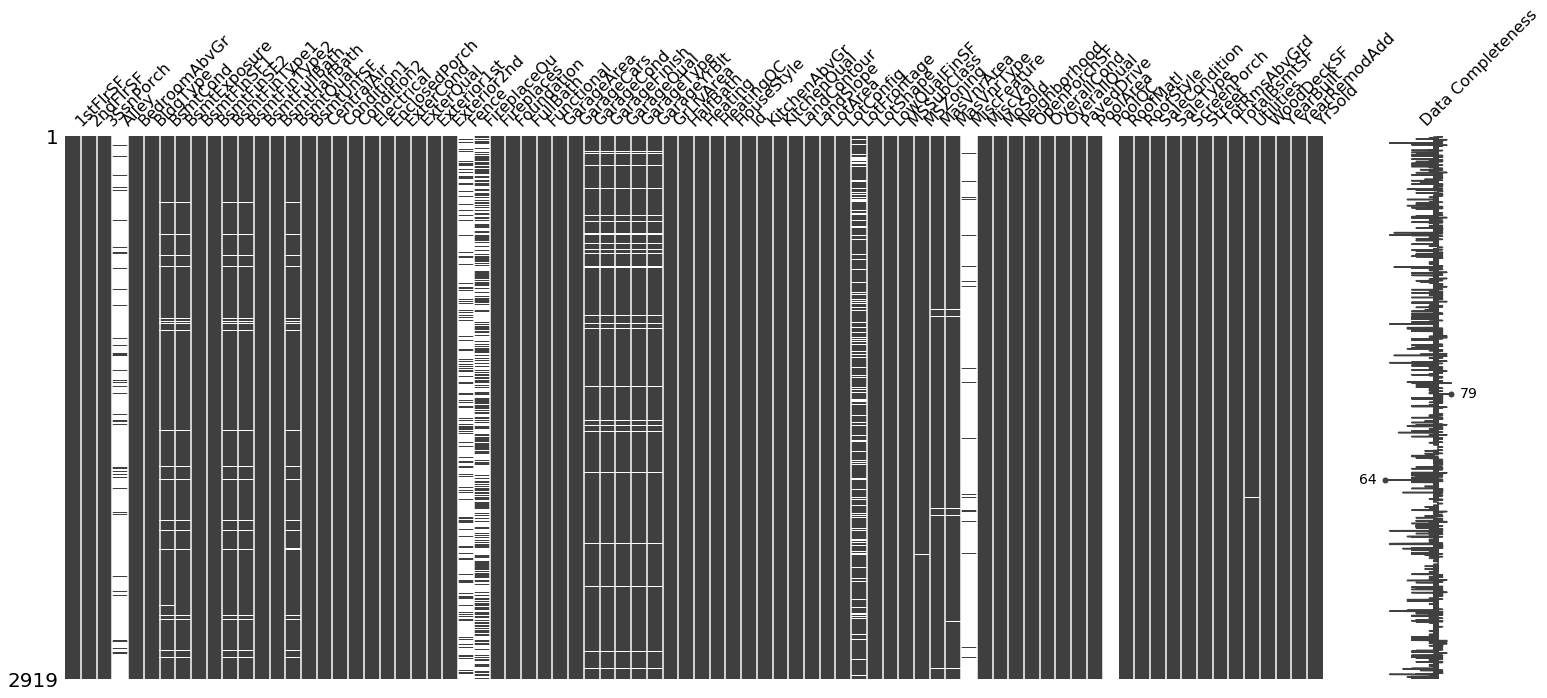

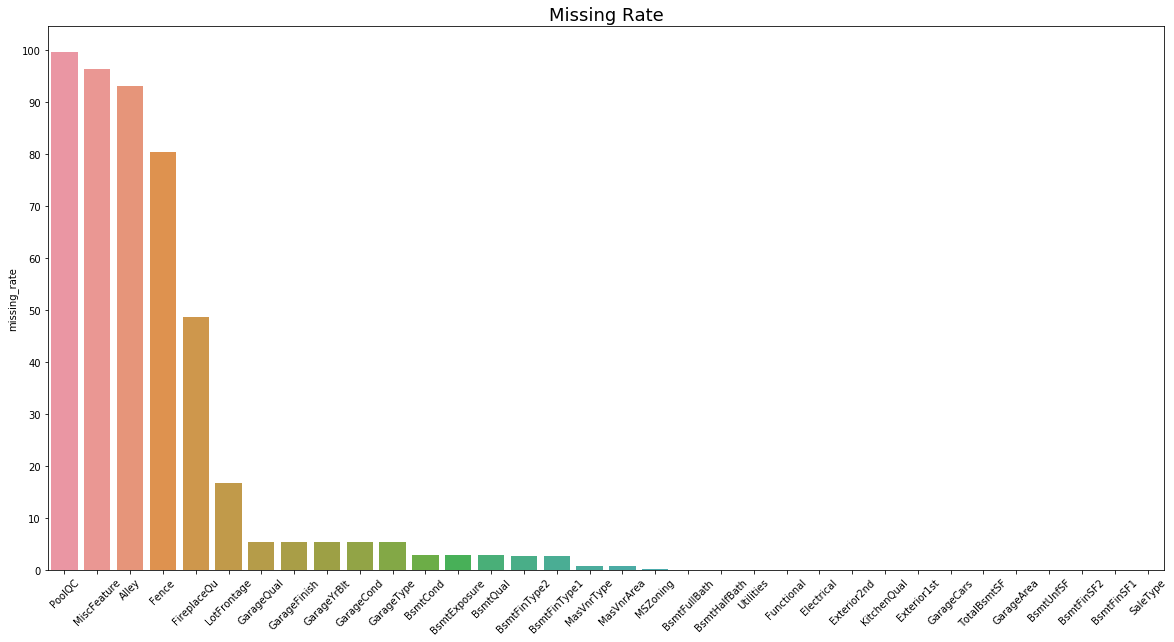

In [132]:
# Missing values visualization(all data)
msno.matrix(all_data, labels=True)
missing_count = all_data.isnull().sum().sort_values(ascending=False)
missing_rate = all_data.isnull().mean().sort_values(ascending=False)
missing_data = pd.concat([missing_count, missing_rate], axis=1, keys=['missing_count', 'missing_rate'])
missing_data = missing_data[missing_data['missing_rate'] > 0]
print('Missing values(col_num=%d)'.center(50, '-') % len(missing_data))
print(missing_data)

plt.figure(figsize=(20, 10))
sns.barplot(x=missing_data.index, y=missing_data['missing_rate'] * 100)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 110, 10))
plt.title('Missing Rate', fontsize=18)

In [133]:
# Delete columns which missing rate > 0.95
missing_thresh = 0.95
high_missing_cols = missing_data[missing_data['missing_rate'] > missing_thresh].index
all_data = all_data.drop(high_missing_cols, axis=1)
print('missing columns:'.center(50, '-'), '\n', missing_data.sort_index().index.tolist())
print('Deleted cols:'.center(50, '-'), '\n', list(high_missing_cols), ', data shape:', all_data.shape)

-----------------missing columns:----------------- 
 ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SaleType', 'TotalBsmtSF', 'Utilities']
------------------Deleted cols:------------------- 
 ['PoolQC', 'MiscFeature'] , data shape: (2919, 78)


In [134]:
# Imputing missing values

# refer to data description
all_data['Alley'] = all_data['Alley'].fillna('None')
all_data['Fence'] = all_data['Fence'].fillna('None')
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

# LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ['GarageQual', 'GarageFinish', 'GarageCond', 'GarageType']:
    all_data[col] = all_data[col].fillna('None')
for col in ['GarageArea', 'GarageCars', 'GarageYrBlt']:
    all_data[col] = all_data[col].fillna(0)

# Basement
for col in ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']:
    all_data[col] = all_data[col].fillna('None')
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF']:
    all_data[col] = all_data[col].fillna(0)

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['Functional'] = all_data['Functional'].fillna(all_data['Functional'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])

all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)

print(all_data.isnull().sum().max())

0


In [135]:
# Transforming some numerical variables that are really categorical
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [136]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [137]:
# Label Encoding some categorical variables that may contain information in their ordering set
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 79)


In [138]:
# Numeric data
numeric_columns = all_data.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('Id')
numeric_data = all_data[numeric_columns]
num_des = numeric_data.describe().T.assign(nunique=numeric_data.apply(lambda x: x.nunique()),
                         missing_rate=numeric_data.apply(lambda x: x.isnull().mean()),
                         mode=numeric_data.apply(lambda x: x.mode()[0]),
                         mode_pct=numeric_data.apply(lambda x: sum(x == x.mode()[0]) / len(all_data)),
                         skew=numeric_data.apply(lambda x: x.dropna().skew())).sort_values('mode_pct', ascending=False)
num_des

count       mean       std       min       25%       50%        75%         max  nunique  missing_rate      mode  mode_pct    skew
Street         2919.000      0.996     0.064     0.000     1.000     1.000      1.000       1.000        2         0.000     1.000     0.996 -15.508
PoolArea       2919.000      2.252    35.664     0.000     0.000     0.000      0.000     800.000       14         0.000     0.000     0.996  16.907
3SsnPorch      2919.000      2.602    25.188     0.000     0.000     0.000      0.000     508.000       31         0.000     0.000     0.987  11.382
LowQualFinSF   2919.000      4.694    46.397     0.000     0.000     0.000      0.000    1064.000       36         0.000     0.000     0.986  12.095
MiscVal        2919.000     50.826   567.402     0.000     0.000     0.000      0.000   17000.000       38         0.000     0.000     0.965  21.958
KitchenAbvGr   2919.000      1.045     0.214     0.000     1.000     1.000      1.000       3.000        4         0.000     1.000     0.954   4.304
LandSlope      2919.000      0.054     0.249     0.000     0.000     0.000      0.000       2.000        3         0.000     0.000     0.952   4.978
BsmtHalfBath   2919.000      0.061     0.246     0.000     0.000     0.000      0.000       2.000        3         0.000     0.000     0.940   3.934
CentralAir     2919.000      0.933     0.250     0.000     1.000     1.000      1.000       1.000        2         0.000     1.000     0.933  -3.461
Alley          2919.000      0.986     0.260     0.000     1.000     1.000      1.000       2.000        3         0.000     1.000     0.932  -0.652
Functional     2919.000      5.760     0.935     0.000     6.000     6.000      6.000       6.000        7         0.000     6.000     0.931  -4.058
ScreenPorch    2919.000     16.062    56.184     0.000     0.000     0.000      0.000     576.000      121         0.000     0.000     0.912   3.949
GarageCond     2919.000      4.764     0.803     0.000     5.000     5.000      5.000       5.000        6         0.000     5.000     0.909  -3.598
PavedDrive     2919.000      1.831     0.537     0.000     2.000     2.000      2.000       2.000        3         0.000     2.000     0.905  -2.981
BsmtCond       2919.000      3.674     0.977     0.000     4.000     4.000      4.000       4.000        5         0.000     4.000     0.893  -2.864
GarageQual     2919.000      4.690     0.950     0.000     5.000     5.000      5.000       5.000        6         0.000     5.000     0.892  -3.076
BsmtFinSF2     2919.000     49.565   169.179     0.000     0.000     0.000      0.000    1526.000      272         0.000     0.000     0.881   4.148
ExterCond      2919.000      3.709     0.774     0.000     4.000     4.000      4.000       4.000        5         0.000     4.000     0.869  -2.499
BsmtFinType2   2919.000      5.550     1.274     0.000     6.000     6.000      6.000       6.000        7         0.000     6.000     0.854  -3.046
EnclosedPorch  2919.000     23.098    64.244     0.000     0.000     0.000      0.000    1012.000      183         0.000     0.000     0.843   4.006
Fence          2919.000      3.494     1.091     0.000     4.000     4.000      4.000       4.000        5         0.000     4.000     0.804  -1.995
BsmtExposure   2919.000      2.328     1.151     0.000     2.000     3.000      3.000       4.000        5         0.000     3.000     0.652  -1.115
LotShape       2919.000      1.948     1.410     0.000     0.000     3.000      3.000       3.000        4         0.000     3.000     0.637  -0.618
HalfBath       2919.000      0.380     0.503     0.000     0.000     0.000      1.000       2.000        3         0.000     0.000     0.628   0.695
ExterQual      2919.000      2.531     0.702     0.000     2.000     3.000      3.000       3.000        4         0.000     3.000     0.616  -1.802
MasVnrArea     2919.000    101.396   178.855     0.000     0.000     0.000    163.500    1600.000      444         0.000     0.000     0.603   2

In [139]:
# Delete columns which mode_pct > 0.95
mode_pct = num_des[num_des['mode_pct'] > 0.95].index.tolist()
all_data.drop(mode_pct, axis=1, inplace=True)
num_des = num_des[num_des['mode_pct'] <= 0.95]
numeric_columns = [col for col in numeric_columns if col not in mode_pct]
print('Deleted columns:', list(mode_pct))

Deleted columns: ['Street', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal', 'KitchenAbvGr', 'LandSlope']


In [140]:
# Box Cox Transformation of (highly) skewed features
skewness = num_des[abs(num_des['skew']) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 30 skewed numerical features to Box Cox transform


In [141]:
# Categorical data
categorical_columns = all_data.select_dtypes(include='object').columns
cat_des = all_data[categorical_columns].describe().T.assign(top_pct=lambda x: x['freq'] / len(all_data),
                    missing_rate=all_data.apply(lambda x: x.isnull().mean())).sort_values('top_pct', ascending=False)
cat_des

count unique      top  freq top_pct  missing_rate
Utilities      2919      2   AllPub  2918   1.000         0.000
Condition2     2919      8     Norm  2889   0.990         0.000
RoofMatl       2919      8  CompShg  2876   0.985         0.000
Heating        2919      6     GasA  2874   0.985         0.000
Electrical     2919      5    SBrkr  2672   0.915         0.000
LandContour    2919      4      Lvl  2622   0.898         0.000
SaleType       2919      9       WD  2526   0.865         0.000
Condition1     2919      9     Norm  2511   0.860         0.000
BldgType       2919      5     1Fam  2425   0.831         0.000
SaleCondition  2919      6   Normal  2402   0.823         0.000
RoofStyle      2919      6    Gable  2310   0.791         0.000
MSZoning       2919      5       RL  2269   0.777         0.000
LotConfig      2919      5   Inside  2133   0.731         0.000
MasVnrType     2919      4     None  1766   0.605         0.000
GarageType     2919      7   Attchd  1723   0.590         0.000
HouseStyle     2919      8   1Story  1471   0.504         0.000
Foundation     2919      6    PConc  1308   0.448         0.000
Exterior1st    2919     15  VinylSd  1026   0.351         0.000
Exterior2nd    2919     16  VinylSd  1015   0.348         0.000
Neighborhood   2919     25    NAmes   443   0.152         0.000

In [142]:
top_pct = cat_des[cat_des['top_pct'] > 0.95].index.tolist()
all_data.drop(top_pct, axis=1, inplace=True)
print('Deleted columns:', top_pct)
cat_des = cat_des[cat_des['top_pct'] <= 0.95]
categorical_columns = [col for col in categorical_columns if col not in top_pct]

Deleted columns: ['Utilities', 'Condition2', 'RoofMatl', 'Heating']


In [ ]:
# Categorical data visualization
grid = GridSpec(16, 2)
plt.figure(figsize=(10 * 2, 16 * 6))

for i, col in enumerate(categorical_columns):
    # bar
    train_values = train[col].fillna('missing')
    test_values = test[col].fillna('missing')
    labels = set(train_values.unique().tolist() + test_values.unique().tolist())

    train_cnts = [train_values.value_counts().to_dict().get(label, 0) for label in labels]
    test_cnts = [test_values.value_counts().to_dict().get(label, 0) for label in labels]

    x_range = np.arange(len(labels))
    width = 0.35
    try:
        ax1 = plt.subplot(grid[2 * i])
    except:
        print(i)
    ax1.bar(x_range - width / 2, train_cnts, width, label='train set')
    ax1.bar(x_range + width / 2, test_cnts, width, label='test set')
    ax1.set_title(col + ' bar', fontsize=18)
    ax1.set_xticks(x_range)
    ax1.set_xticklabels(labels, rotation=45)
    plt.legend()
    
    # boxplot
    ax2 = plt.subplot(grid[2 * i + 1])
    sns.boxplot(x=train[col], y=y_train, ax=ax2)
    ax2.set_title(col, fontsize=18)
    ax2.set_xlabel('')
plt.show()

In [168]:
# Outliers of SalePrice
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(y_train[:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


In [143]:
# Getting dummy categorical features
dummy_data = pd.get_dummies(all_data[categorical_columns])
all_data.drop(categorical_columns, axis=1, inplace=True)
all_data = pd.concat([all_data, dummy_data], axis=1)

train = all_data[:len(train)]
test = all_data[len(train):]
print(all_data.shape)

(2919, 187)


In [144]:
train.sample(5)

1stFlrSF  2ndFlrSF  Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtFinSF1  BsmtFinSF2  BsmtFinType1  BsmtFinType2  BsmtFullBath  BsmtHalfBath  BsmtQual  BsmtUnfSF  CentralAir  EnclosedPorch  \
283    13.238     0.000      1             3     1.820         1.541       0.000       0.000             6         2.260         0.000         0.000         2     13.238       0.730          0.000   
435    11.598    11.621      1             3     1.820         0.000       9.622       9.350             2         0.000         1.000         0.000         2      5.969       0.730          0.000   
265    13.144     0.000      1             3     1.820         1.541      10.688       8.395             2         1.541         0.000         0.000         2     10.767       0.730          0.000   
168    11.641    11.769      1             3     1.820         1.541       0.000       0.000             6         2.260         0.000         0.000         2     11.641       0.730          0.000   
493    12.808     0.000      1             3     1.820         1.541       9.552      10.430             1         1.541         0.000         0.000         4      9.480       0.730          0.000   

     ExterCond  ExterQual  Fence  FireplaceQu  Fireplaces  FullBath  Functional  GarageArea  GarageCars  GarageCond  GarageFinish  GarageQual  GarageYrBlt  GrLivArea  HalfBath  HeatingQC   Id  \
283      1.820      1.194  1.820            2           1         2       2.260     898.000       3.000       2.056             0       2.056       14.195     13.238         0          0  284   
435      1.820      1.194  1.820            5           1         2       2.260     550.000       2.000       2.056             2       2.056       14.177     13.610         1          0  436   
265      1.194      1.541  0.000            5           1         2       2.260     576.000       2.000       2.056             0       2.056       14.153     13.144         0          4  266   
168      1.820      1.194  1.820            2           1         2       2.260     440.000       2.000       2.056             0       2.056       14.189     13.717         1          0  169   
493      1.820      1.541  1.820            1           1         1       2.260     308.000       1.000       2.056             3       2.056       14.126     12.808         1          4  494   

     KitchenQual  LotArea  LotFrontage  LotShape  MSSubClass  MasVnrArea  MoSold  OpenPorchSF  OverallCond  OverallQual  PavedDrive  ScreenPorch  TotRmsAbvGrd  TotalBsmtSF  WoodDeckSF  YearBuilt  \
283        1.194   19.717        6.073         3           5       6.022       3        7.483            4            8       1.194        0.000         2.260       13.238       8.212       2008   
435        1.194   20.132        5.094         1          10       0.000       6        5.715            5            7       1.194        0.000         2.260       11.504       7.593       1996   
265        1.194   20.641        6.173         0           5       8.212       8        0.000            5            6       1.194        0.000         2.440       13.144       8.832       1981   
168        1.194   19.117        5.744         0          10       0.000       7        5.285            4            7       1.194        0.000         2.440       11.641       6.655       2004   
493        1.541   18.967        5.969         3           5       0.000       8        0.000            5            5       1.194        0.000         2.260       12.808       0.000       1960   

     YearRemodAdd  ...  MasVnrType_BrkCmn  MasVnrType_BrkFace  MasVnrType_None  MasVnrType_Stone  Neighborhood_Blmngtn  Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  \
283          2009  ...                  0                   0                0                 1                     0                     0                    0                     0   
435          1996  ...                  0                   0         

skewness: 1.8828757597682129
kurtosis: 6.536281860064529


count      1460.000
mean     180921.196
std       79442.503
min       34900.000
25%      129975.000
50%      163000.000
75%      214000.000
max      755000.000
Name: SalePrice, dtype: float64

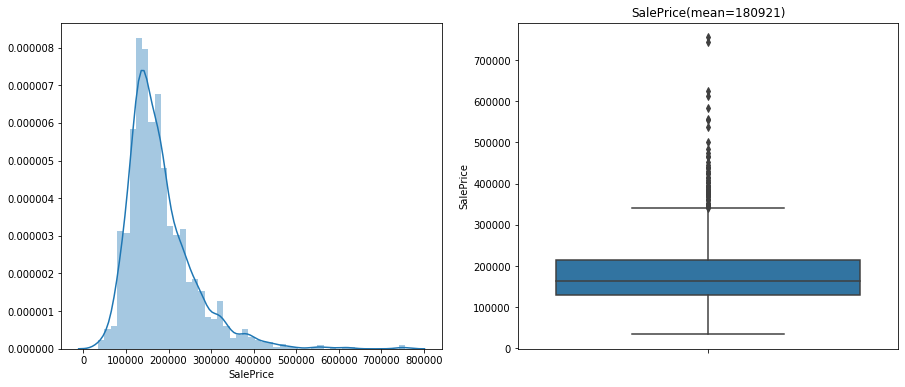

In [145]:
# SalePrice
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(y_train, ax=ax1)
sns.boxplot(y=y_train, ax=ax2)
plt.title('SalePrice(mean=%d)' % int(y_train.mean()))
print('skewness:', y_train.skew())
print('kurtosis:', y_train.kurtosis())
y_train.describe()

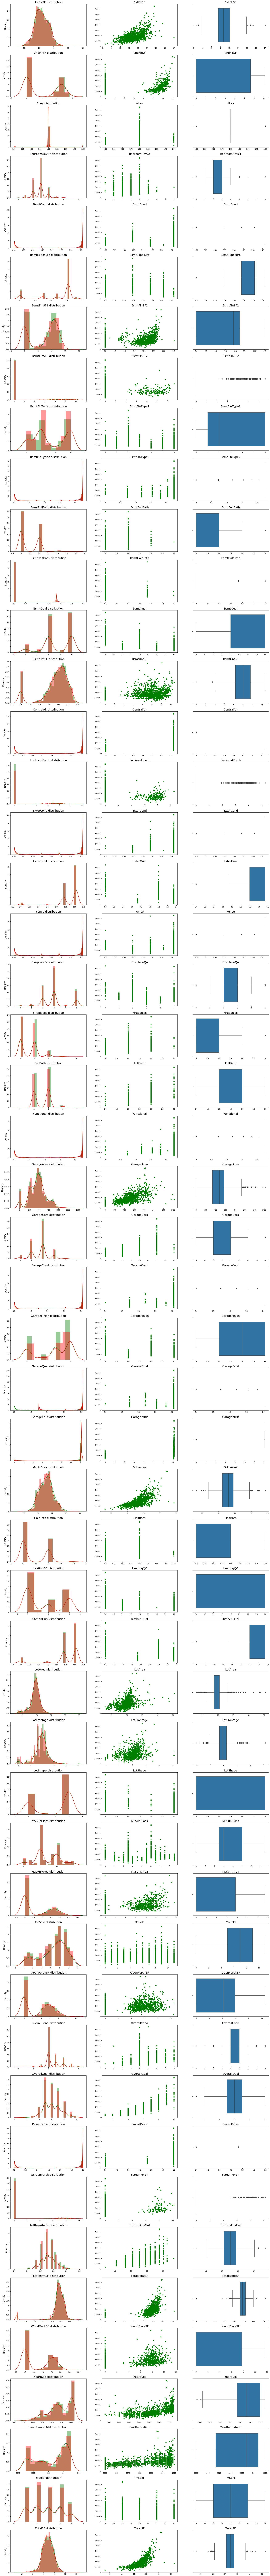

In [150]:
# Numeric data visualization
grid = GridSpec(51, 3)
plt.figure(figsize=(10 * 3, 51 * 6))
for i, col in enumerate(numeric_columns):
    # distplot
    ax1 = plt.subplot(grid[i * 3])
    sns.distplot(train[col], color='g', ax=ax1)
    sns.distplot(test[col].fillna(-1), color='r', ax=ax1)
    ax1.set_title(f'{col} distribution', fontsize=18)
    ax1.set_ylabel('Density', fontsize=15)
    ax1.set_xlabel(None)
    
    # scatter plot
    ax2 = plt.subplot(grid[i * 3 + 1])
    ax2.scatter(x=train[col], y=y_train, color='g')
    ax2.set_title(col, fontsize=18)
    
    # boxplot
    ax3 = plt.subplot(grid[i * 3 + 2])
    sns.boxplot(x=col, data=train, ax=ax3)
    ax3.set_title(col, fontsize=18)
    ax3.set_xlabel(None)

plt.show()

In [ ]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

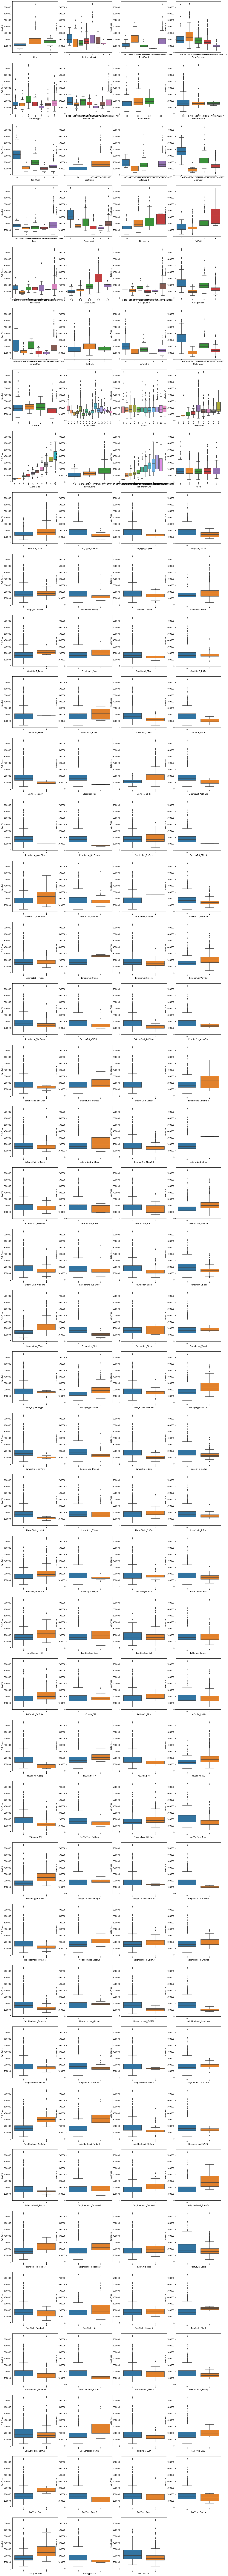

In [152]:
numeric_cols_box = train.select_dtypes(include='number').nunique()
numeric_cols_box = numeric_cols_box[numeric_cols_box <= 20]
nrows = int(np.ceil(len(numeric_cols_box) / 4))
gs = GridSpec(nrows, 4)
plt.figure(figsize=(20, nrows*6))
for i, col in enumerate(numeric_cols_box.index.values):
    ax = plt.subplot(gs[i])
    sns.boxplot(x=train[col], y=y_train, data=train, ax=ax)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

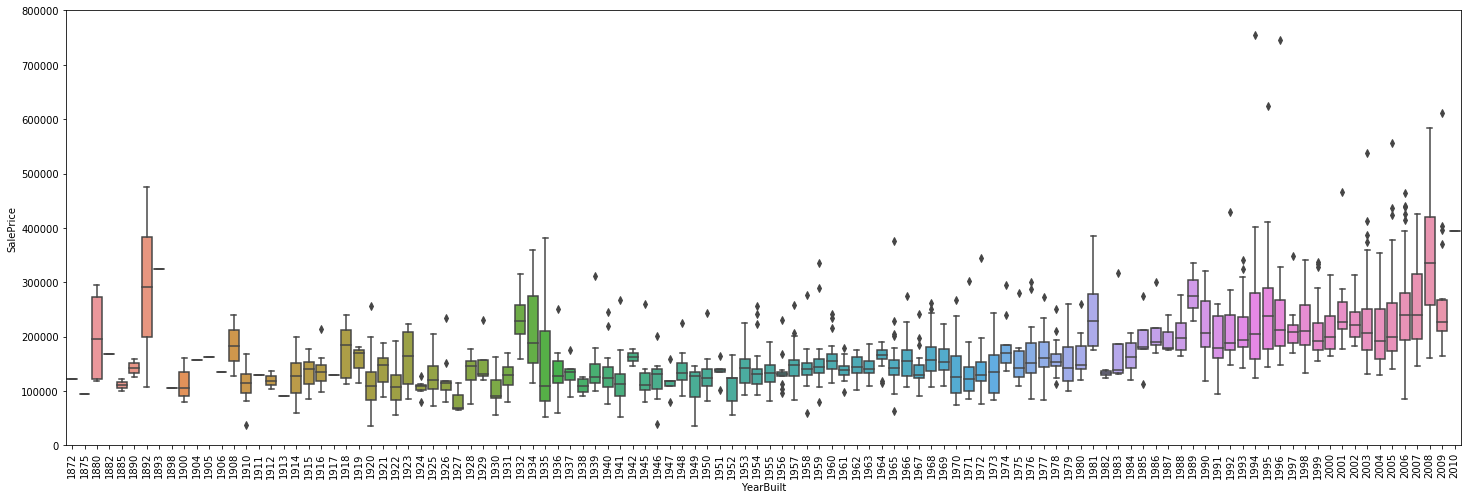

In [153]:
var = 'YearBuilt'
data = pd.concat([y_train, train[var]], axis=1)
f, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x=data[var], y=y_train, data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90)

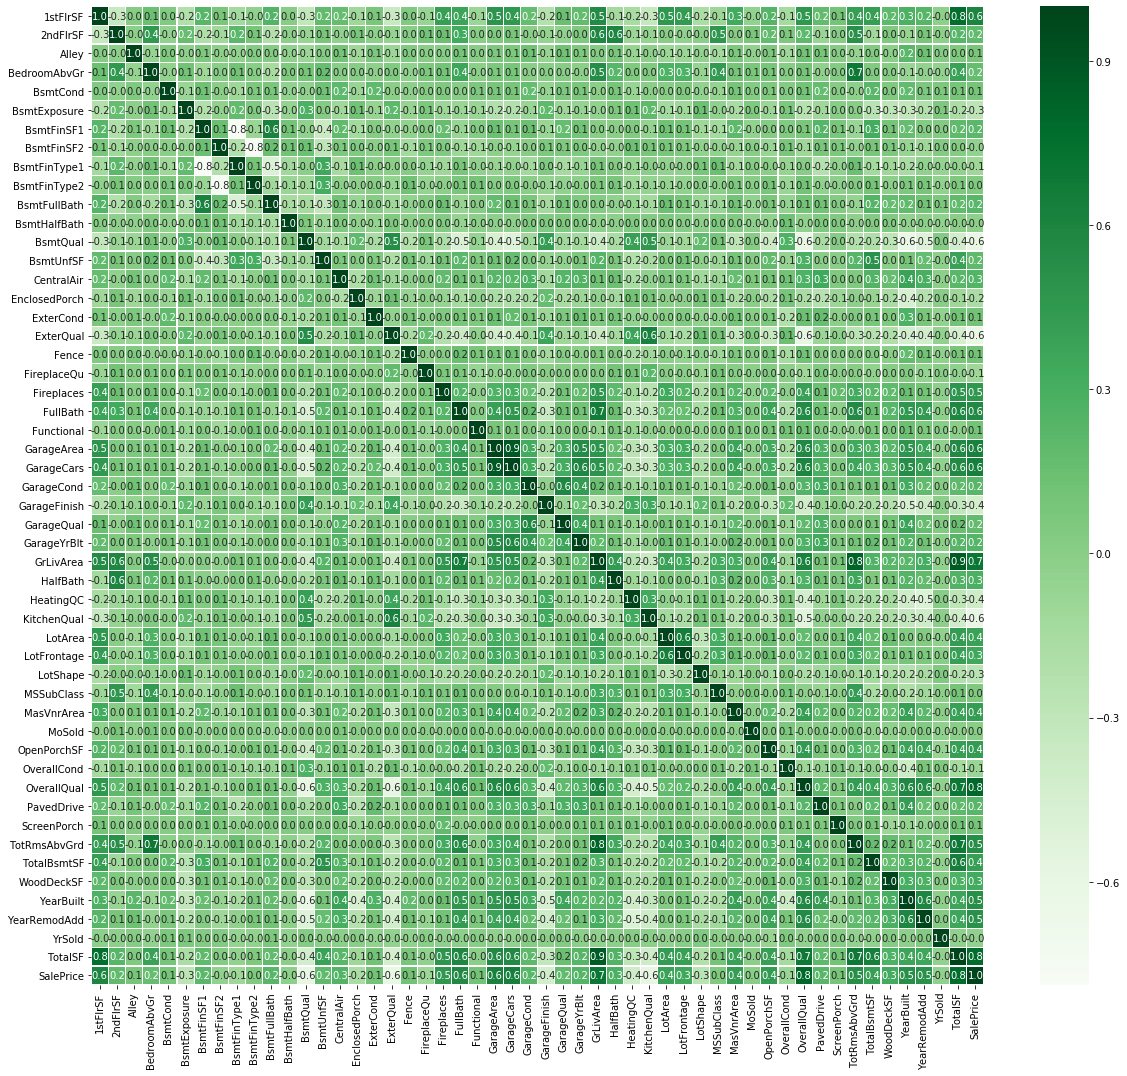

In [158]:
# Correlations between numeric columns
corrmat = pd.concat([train[numeric_columns], y_train], axis=1).corr()
plt.figure(figsize=(20, 18))
sns.heatmap(corrmat, cmap=plt.cm.Greens, fmt='.1f', annot=True, linecolor='w', linewidths=.1)

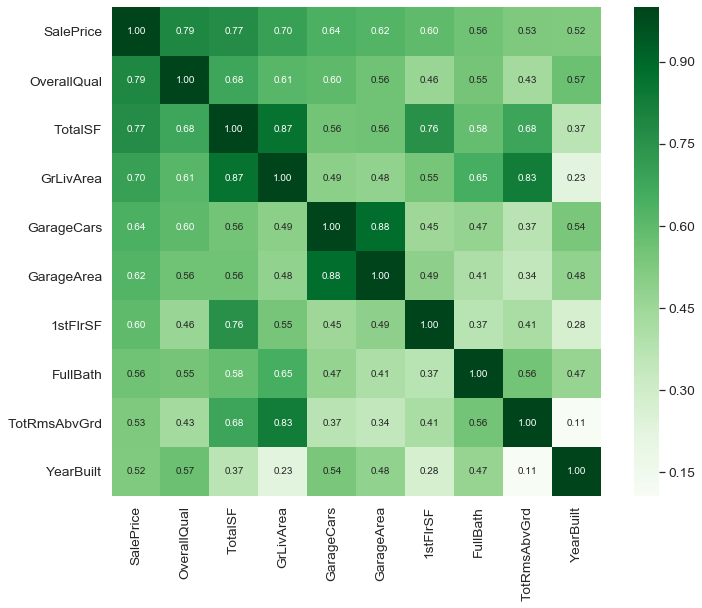

In [160]:
# Plot heatmap between SalePrice and other columns which has the highest top 10 corr.
plt.figure(figsize=(12, 9))
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(pd.concat([train, y_train], axis=1)[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap=plt.cm.Greens)
plt.show()

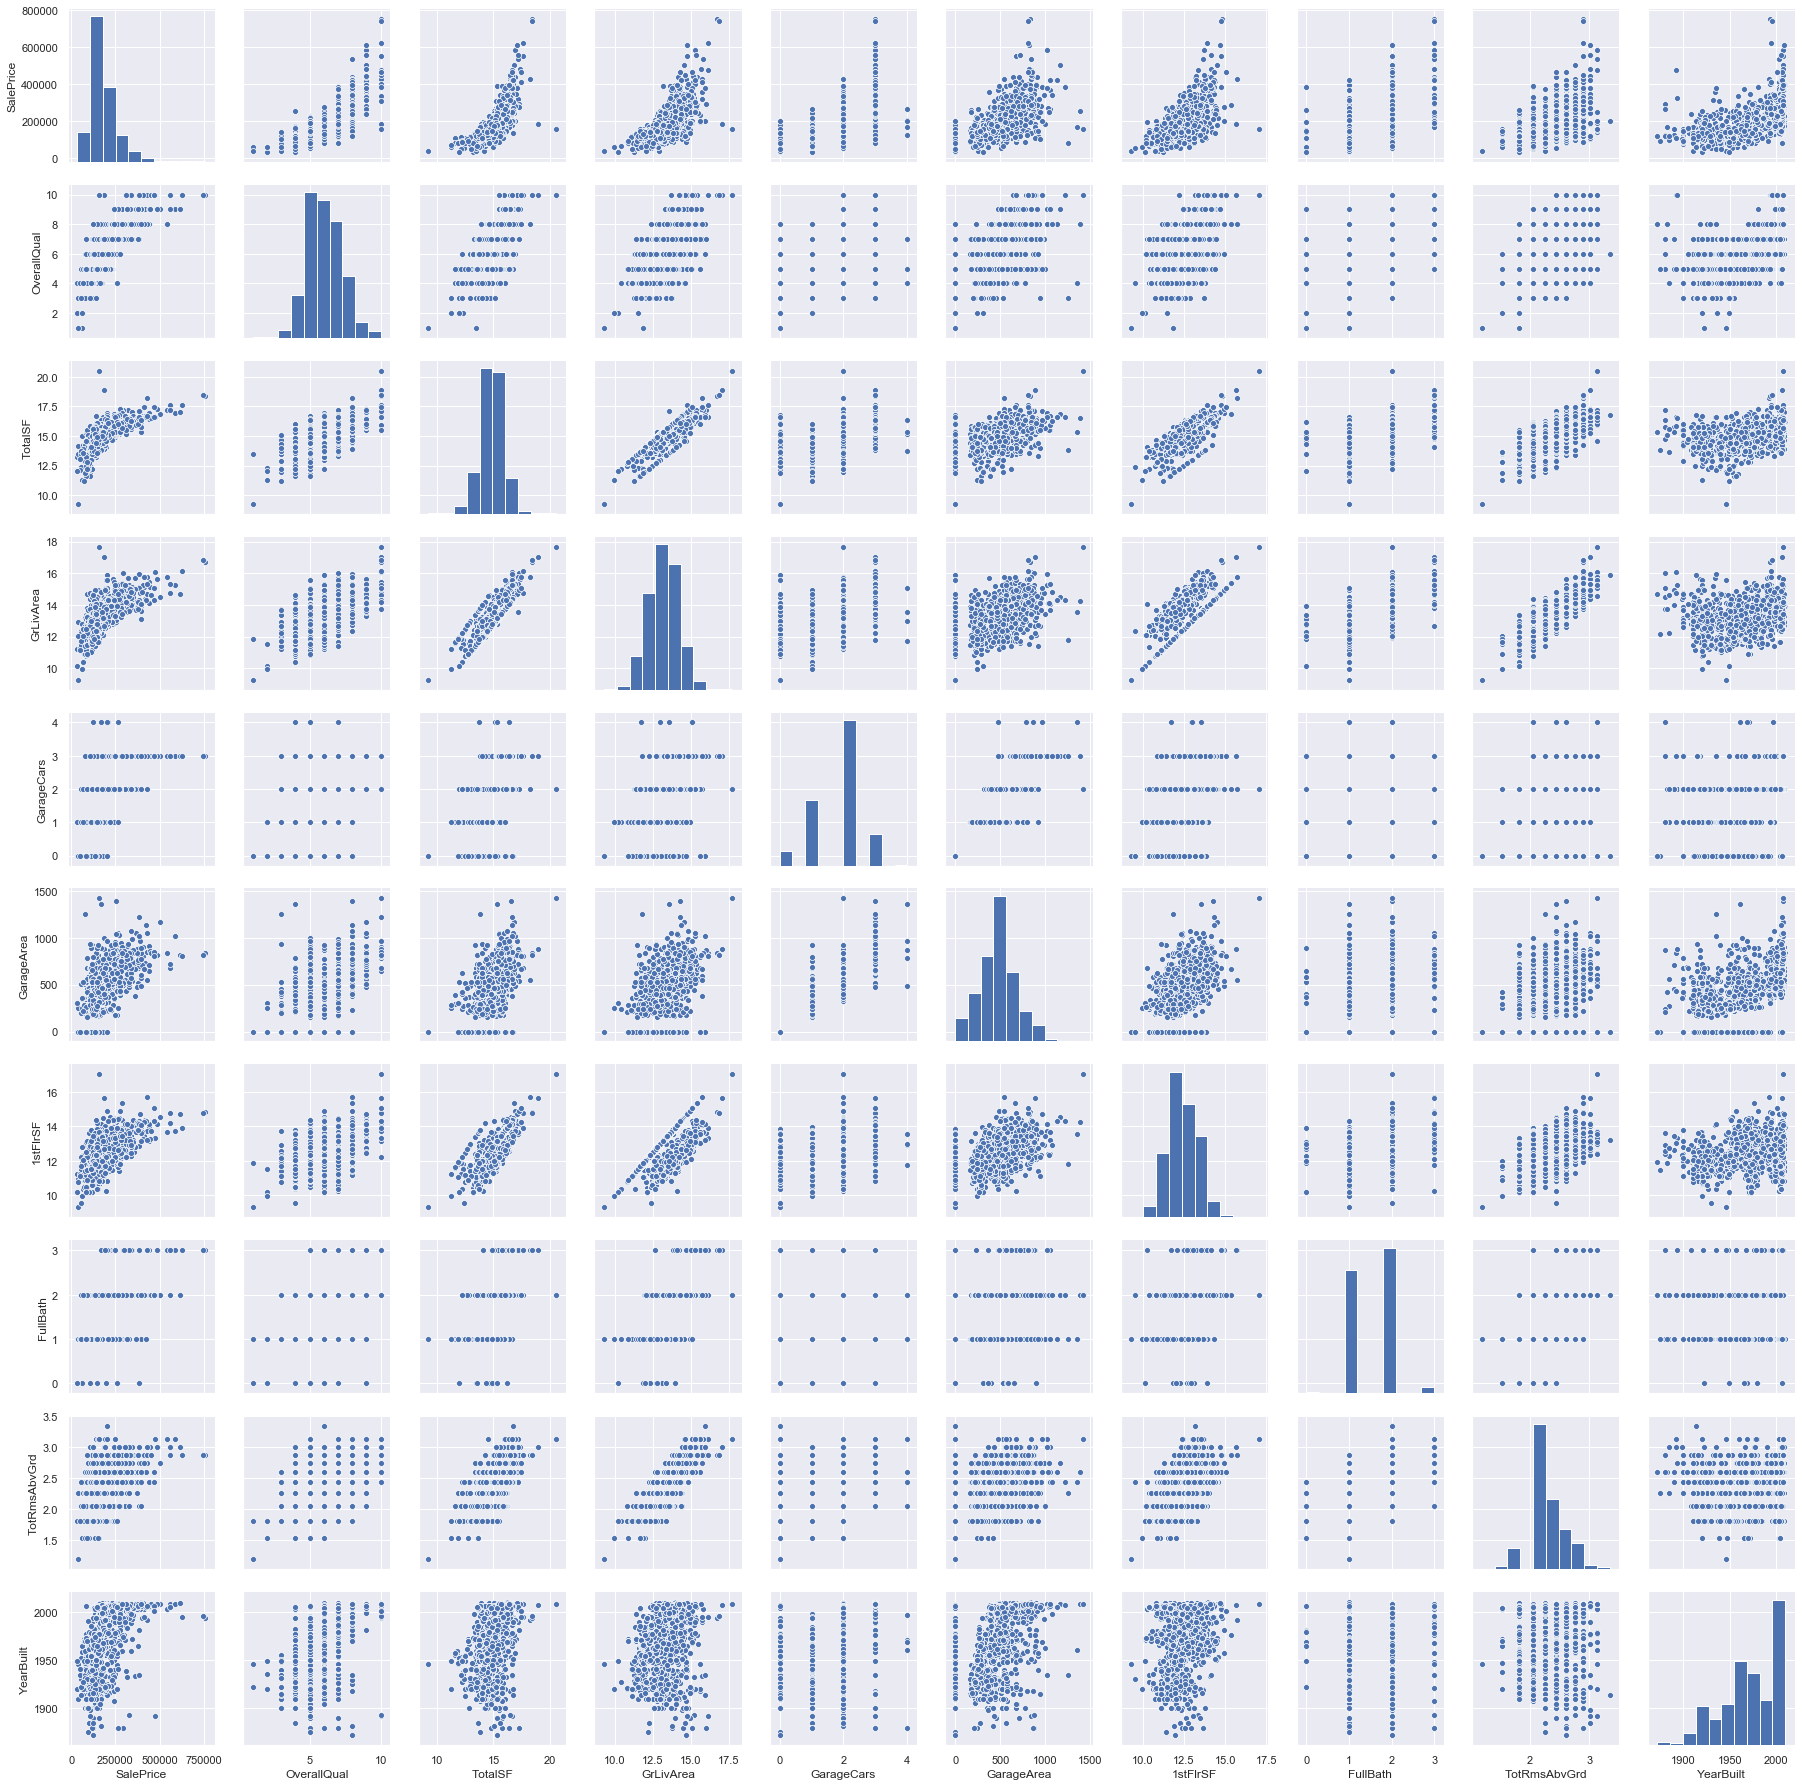

In [163]:
# Scatter plots between 'SalePrice' and correlated variables
sns.set()
cols = ['SalePrice', 'OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars', 'GarageArea', 
        '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
sns.pairplot(pd.concat([train, y_train], axis=1)[cols], size = 2.5)

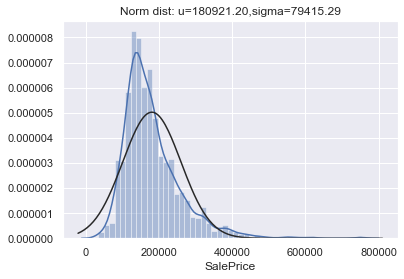

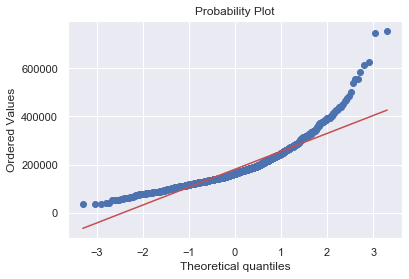

In [169]:
# Normality Homoscedasticity Linearity Absence of correlated errors
# In the search for normality
#histogram and normal probability plot
(mu, sigma) = norm.fit(y_train)
plt.title('Norm dist: u={:.2f},sigma={:.2f}'.format(mu, sigma))
sns.distplot(y_train, fit=norm);
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)

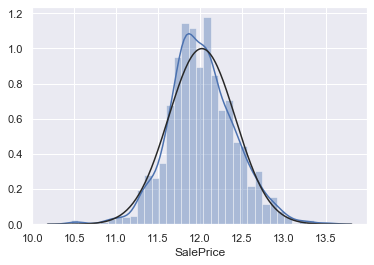

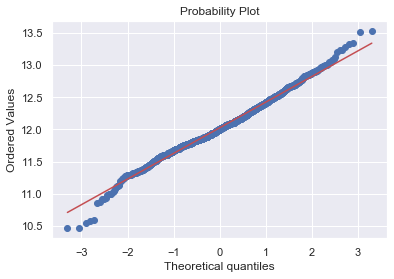

In [183]:
# Ok, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.
#But everything's not lost. A simple data transformation can solve the problem. 
#This is one of the awesome things you can learn in statistical books: in case of positive skewness,
#log transformations usually works well. When I discovered this, I felt like an Hogwarts' student discovering a new cool spell.
#applying log transformation
y_train = np.log(y_train)
#transformed histogram and normal probability plot
sns.distplot(y_train, fit=norm);
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)

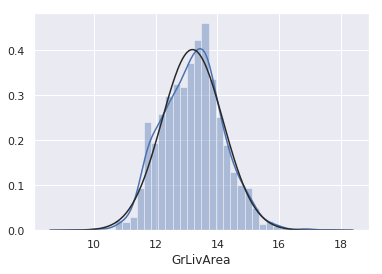

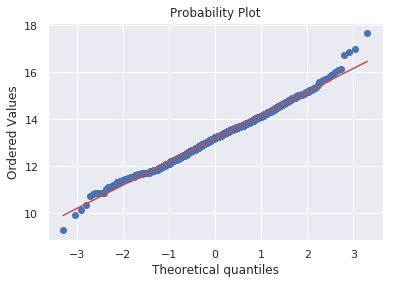

In [29]:
#histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

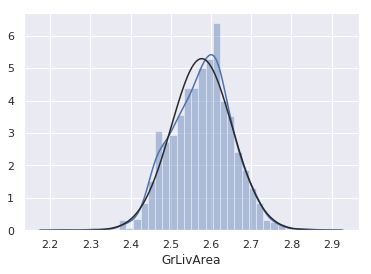

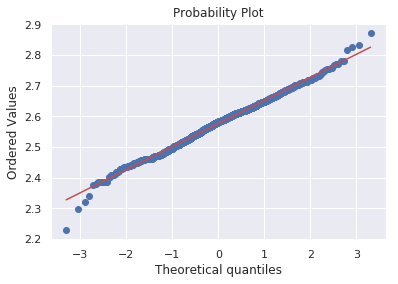

In [30]:
#data transformation
train['GrLivArea'] = np.log(train['GrLivArea'])
#transformed histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

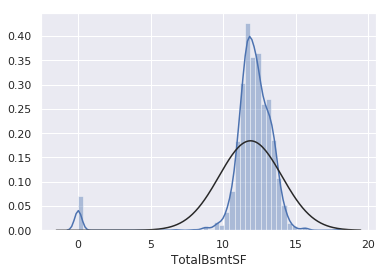

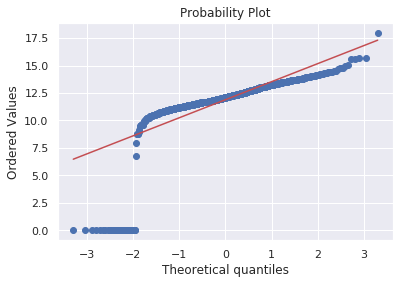

In [31]:
#histogram and normal probability plot
sns.distplot(train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

In [32]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
def log_transform(train):
    train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
    train['HasBsmt'] = 0 
    train.loc[train['TotalBsmtSF']>0,'HasBsmt'] = 1

    #transform data
    train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])
    return train

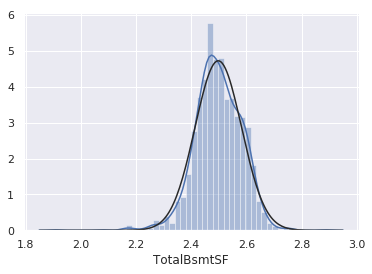

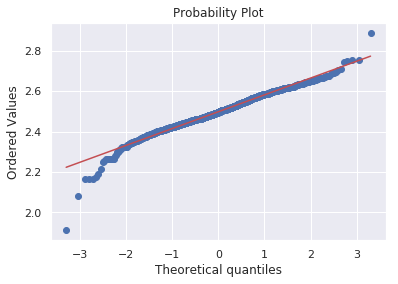

In [33]:
train = log_transform(train)
#histogram and normal probability plot
sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

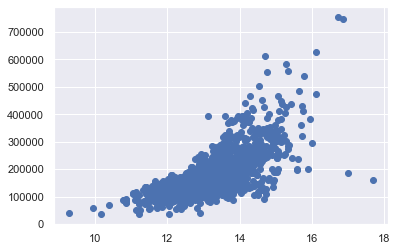

In [171]:
# In the search for writing 'homoscedasticity' right at the first attempt
#scatter plot
plt.scatter(train['GrLivArea'], y_train);

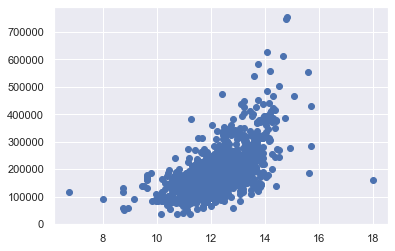

In [172]:
#scatter plot
plt.scatter(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], y_train[train[train['TotalBsmtSF']>0].index]);

In [173]:
# prediction visualization
def plot_mse(y_pred, title, response=False):
    plt.figure(figsize=(15, 6))
    x = np.arange(len(y_pred))
    if str(response) != 'False':
        sort = np.argsort(response)
        plt.plot(x, y_pred[sort], color='r', label='Pred')
        plt.plot(x, np.sort(response), color='g', label='Real')
        plt.title(f'{title}(MSE={round(mean_squared_error(response, y_pred))})', fontsize=18)
    else:
        plt.plot(x, np.sort(y_pred), color='r', label='Pred')
    plt.legend()
    plt.show()

In [42]:
# Existing problem: overfit

In [175]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train.values, scoring="neg_mean_squared_error", cv = kf))
    return rmse

In [45]:
# Base Models

In [176]:
# LASSO Regression
# This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [177]:
# Elastic Net Regression :
# again made robust to outliers
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [178]:
# Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [179]:
# Gradient Boosting Regression :
# With huber loss that makes it robust to outliers
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [180]:
# XGBoost :
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [181]:
# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [52]:
# Base models scores
# Let's see how these base models perform on the data by evaluating the cross-validation rmsle error

In [184]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))



Lasso score: 0.1237 (0.0153)

ElasticNet score: 0.1237 (0.0152)

Kernel Ridge score: 0.1991 (0.0222)

Gradient Boosting score: 0.1231 (0.0109)

Xgboost score: 0.1212 (0.0099)

LGBM score: 0.1220 (0.0090)



In [185]:
# Stacking models
# Simplest Stacking approach : Averaging base models
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [186]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1256 (0.0118)



In [187]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [188]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1192 (0.0140)


In [189]:
# Ensembling StackedRegressor, XGBoost and LightGBM
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [190]:
# StackedRegressor
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.08734385932007864


In [191]:
# XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0787283722689637


In [192]:
# LightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.0740917114321923


In [193]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.08116391783778666


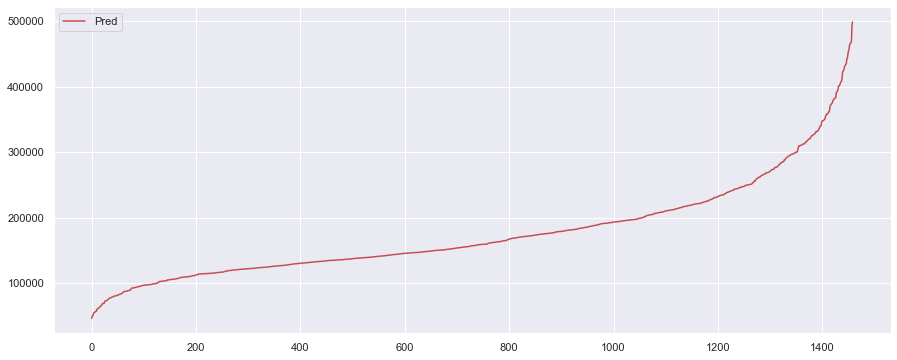

In [201]:
# Ensemble prediction
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

plot_mse(ensemble, title=None)

In [195]:
# Submission
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

In [202]:
# Entries:1,score:0.11911
# Entries:2,score:0.11801,859/3213,top20%